# Shifted Beta Geometric model with population data

In this notebook we replicate the main results and figures from 

Fader, P. S., & Hardie, B. G. (2007). How to project customer retention. Journal of Interactive Marketing, 21(1), 76-90. https://journals.sagepub.com/doi/pdf/10.1002/dir.20074

The authors describe the Shifted Beta Geometric (sBG) model for customer behavior in a discrete contractual setting. It assumes that:
  * At the end of each period, a customer has a probability `theta` of renewing the contract
    and `1-theta` of cancelling
  * The probability `theta` does not change over time for a given customer
  * The probability `theta` varies across customers according to a Beta prior distribution
    with hyperparameters `alpha` and `beta`.

In [1]:
import pytensor

#set flag to hotfix open c++ errors
pytensor.config.cxx = '/usr/bin/clang++'

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from pymc_marketing import clv
import pymc as pm
from pymc_extras.prior import Prior

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:

dataset = pd.read_csv("https://raw.githubusercontent.com/ColtAllen/pymc-marketing/refs/heads/clv-sbg-model/data/sbg_paper.csv")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  2000 non-null   int64 
 1   recency      2000 non-null   int64 
 2   T            2000 non-null   int64 
 3   cohorts      2000 non-null   object
dtypes: int64(3), object(1)
memory usage: 62.6+ KB


## Fitting the sBG models for high end and regular user cohorts

In [4]:
sbg = clv.ShiftedBetaGeoModel(
    data=dataset,
    model_config = {
        "alpha": Prior("HalfFlat",dims="cohorts"),
        "beta": Prior("HalfFlat",dims="cohorts"),
    }
)
sbg.build_model()
sbg.fit(fit_method='map')

Output()

Inference data with groups:
	> posterior
	> observed_data
	> fit_data

## Contrasting posterior inferences with the repo MLE estimates

In [5]:
# MLE estimates from the paper
ref_val = {
    "highend": [0.688, 3.806],
    "regular": [0.704, 1.182],
}
sbg.fit_summary()
#az.plot_trace(sbg.idata,var_names=["alpha", "beta"])

alpha[highend]    0.668
alpha[regular]    0.704
beta[highend]     3.806
beta[regular]     1.182
Name: value, dtype: float64

# Predictive Methods

In [6]:
# predictions can only be ran on active customers
active_df = dataset[dataset["recency"] == dataset["T"]].copy()

In [15]:
sbg.expected_probability_alive(active_df,future_t=0).mean(("chain","draw")).to_pandas()

customer_id
510     0.460441
511     0.460441
512     0.460441
513     0.460441
514     0.460441
          ...   
1996    0.220085
1997    0.220085
1998    0.220085
1999    0.220085
2000    0.220085
Length: 732, dtype: float64

In [16]:
sbg.expected_retention_rate(active_df,future_t=0).mean(("chain","draw")).to_pandas()

customer_id
510     0.941775
511     0.941775
512     0.941775
513     0.941775
514     0.941775
          ...   
1996    0.920767
1997    0.920767
1998    0.920767
1999    0.920767
2000    0.920767
Length: 732, dtype: float64

In [18]:
sbg.expected_lifetime_purchases(active_df).mean(("chain","draw")).to_pandas()

customer_id
510     inf
511     inf
512     inf
513     inf
514     inf
       ... 
1996    inf
1997    inf
1998    inf
1999    inf
2000    inf
Length: 732, dtype: float64

In [19]:
sbg.expected_retention_elasticity(active_df).mean(("chain","draw")).to_pandas()

customer_id
510     inf
511     inf
512     inf
513     inf
514     inf
       ... 
1996    inf
1997    inf
1998    inf
1999    inf
2000    inf
Length: 732, dtype: float64

### Latent Dropout Distribution for Customer Population
The way latent distributions are currently sample in other CLV models does not translate well to censored multidims. This functionality will be added in a future PR, based on the below code to be used in the tuturial notebook:

In [ ]:
alpha_fit = sbg.fit_result["alpha"]
beta_fit = sbg.fit_result["beta"]

rng = np.random.default_rng(42)
theta_sim = rng.beta(alpha_fit,beta_fit)

theta = xr.DataArray(
    theta_sim,
    dims=("chains","draws","cohort"),
    coords={
        "chains": np.arange(4), 
        "draws": np.arange(1000),
        "cohort": ["highend","regular"],
    },
    name="theta",
)

az_theta = az.convert_to_inference_data(theta)

highend = az_theta.sel(cohort="highend")
highend
highend.posterior["theta"].values.flatten()

az.plot_dist(highend.posterior["theta"].values.flatten())

az_theta.mean(("chains","draws"))

# plot this by cohort
theta
az.plot_dist(theta)

The sBG model has 2 population parameters of interest: `alpha` and `beta`. 
These parameters define the population distribution of the individual customer's churn rates `theta`. 
The larger the values of `alpha` and `beta` the more homogenous the churn rates are across different customers. 

The ratio of `alpha` to `beta` tells us the expected churn rates. If `alpha/beta == 0.1`, we expect the average customer to have a `0.1` probability of churning between each time period.

In [ ]:
# Map cohort-wise [alpha, beta] refs to ArviZ variable labels
ref_val_map = {}
for cohort, (a_ref, b_ref) in ref_val.items():
    ref_val_map[f"alpha\n{cohort}"] = a_ref
    ref_val_map[f"beta\n{cohort}"]  = b_ref
   
az.plot_posterior(
    idata,  # InferenceData; uses the posterior group by default
    var_names=["alpha", "beta"],
    ref_val=ref_val_map,
)

The model fitting agrees with the Maximum Likelihood estimates described in the original paper.
In addition, MCMC sampling, gives us useful information about the uncertainty of the fits.

In [ ]:
def retention_rate(alpha,beta,t):
    r_t = (beta+t-1)/(alpha+beta+t-1)
    return r_t

In [ ]:
alpha = .704
beta = 1.182
retention_rate(alpha,beta, dataset_regular["t_churn"].unique())

##### Create Dataset of Cohorts from Companion Papers

In [61]:
import numpy as np
import pandas as pd

# Cohort table from the markdown (empty cells omitted)
# only need the params for unit testing
# alpha 3.80, beta = 15.20
cohort_counts = {
    2001: {2001: 10000, 2002: 8000, 2003: 6480, 2004: 5307, 2005: 4391},
    2002: {2002: 10000, 2003: 8000, 2004: 6480, 2005: 5307},
    2003: {2003: 10000, 2004: 8000, 2005: 6480},
    2004: {2004: 10000, 2005: 8000},
    2005: {2005: 10000},
}

# alpha=0.067, beta=0.267
case2 = {
    2003: {2003: 10000, 2004: 8000, 2005: 7600, 2006: 7383, 2007: 7235},
    2004: {2004: 10000, 2005: 8000, 2006: 7600, 2007: 7383},
    2005: {2005: 10000, 2006: 8000, 2007: 7600},
    2006: {2006: 10000, 2007: 8000},
    2007: {2007: 10000},
}
# (Bottom totals row is intentionally ignored)

rows = []
for cohort, year_counts in cohort_counts.items():
    years_sorted = sorted(year_counts)
    ages = [y - cohort for y in years_sorted]
    S = [year_counts[y] for y in years_sorted]  # survivors per age
    last_t = ages[-1]  # observation window for this cohort (right-censoring time T)

    # Churn in interval t -> t+1 (event observed at t)
    for t in range(len(S) - 1):
        count = S[t] - S[t + 1]
        if count > 0:
            rows.append({"cohort": cohort, "t_churn": t, "T": last_t, "count": count})

    # Right-censored at last observed age (still active)
    if S[-1] > 0:
        rows.append({"cohort": cohort, "t_churn": last_t, "T": last_t, "count": S[-1]})

counts_df = pd.DataFrame(rows)

# Expand to one row per customer
t_churn_array = np.repeat(counts_df["t_churn"].to_numpy(), counts_df["count"].to_numpy())
T_array = np.repeat(counts_df["T"].to_numpy(), counts_df["count"].to_numpy())
cohort_array = np.repeat(counts_df["cohort"].to_numpy(), counts_df["count"].to_numpy())
customer_id = np.arange(t_churn_array.size)

df = pd.DataFrame(
    {
        "customer_id": customer_id + 1,
        "recency": t_churn_array + 1,
        "T": T_array + 1,
        "cohort": cohort_array,
    }
).astype({"customer_id": int, "t_churn": int, "T": int, "cohort": str})

#df.to_csv("sbg_cohorts.csv",index=False)

In [62]:
cohort_idx = pd.Categorical(df["cohort"], categories=df.cohort.unique()).codes

coords = {
    "customer_id": df["customer_id"],
    "cohort": df.cohort.unique(),
}
with pm.Model(coords=coords) as model:
    
    # alpha = pm.HalfFlat("alpha",dims="cohort")
    # beta = pm.HalfFlat("beta",dims="cohort")

    phi = pm.Uniform("phi", lower=0, upper=1)
    kappa = pm.Pareto("kappa", alpha=1,m=1,dims="cohort")

    alpha = pm.Deterministic("alpha", phi * kappa)#,dims=("cohort")
    beta = pm.Deterministic("beta", (1 - phi) * kappa)#,dims=("cohort",))
    # theta = pm.Beta("dropout",alpha=alpha,beta=beta)

    sbg = clv.distributions.ShiftedBetaGeometric.dist(
        alpha[cohort_idx],
        beta[cohort_idx],
    )

    pm.Censored(
        "churn_censored",
        sbg,
        lower=None,
        upper=df["T"],
        observed=df["t_churn"],
        dims="customer_id",
    )

    idata = pm.sample()#nuts_sampler="nutpie")
    #idata = pm.find_MAP()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, kappa]


Output()

ValueError: Not enough samples to build a trace.

In [60]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi,0.202,0.006,0.192,0.213,0.000,0.000,2784.0,2713.0,1.0
kappa[2001],30.032,143.620,6.027,57.344,3.490,47.394,2044.0,1311.0,1.0
kappa[2002],32.732,164.695,3.880,68.265,3.818,39.942,2967.0,1865.0,1.0
kappa[2003],34.233,147.090,2.542,89.432,3.463,31.625,2868.0,1899.0,1.0
kappa[2004],16.202,492.852,1.001,17.390,8.092,243.492,4081.0,2152.0,1.0
kappa[2005],8.292,67.496,1.000,14.676,1.234,15.464,4401.0,2209.0,1.0
alpha[0],5.990,28.030,1.241,11.312,0.679,9.158,2118.0,1325.0,1.0
alpha[1],6.543,32.782,0.780,13.615,0.758,7.957,3034.0,1902.0,1.0
alpha[2],6.875,29.586,0.497,17.502,0.697,6.374,2932.0,1908.0,1.0
alpha[3],3.252,98.293,0.188,3.473,1.616,48.552,4351.0,2374.0,1.0


In [48]:
# map
idata

{'alpha_log__': array([ 1.34115052e+00,  1.34234229e+00,  1.33512149e+00, -6.93143143e-01,
         2.69856324e-13]),
 'beta_log__': array([2.72792517e+00, 2.72881578e+00, 2.72146237e+00, 6.93143143e-01,
        1.60558837e-13]),
 'alpha': array([3.8234399 , 3.82799931, 3.80045765, 0.50000202, 1.        ]),
 'beta': array([15.30110681, 15.31474024, 15.20253766,  1.99999193,  1.        ])}

## Recreating main results and figures from the paper

Figure 6 from the paper shows the group distribution of `theta` churn rates. 

The inferred distributions are relatively wide in both groups, which follows directly from the fact that both `alpha` and `beta` were inferred to be < 10.

It is still clear that the distribution of `theta` for the highend users has much more mass near lower values,
suggesting highend users have lower attrition rates on average, when compared with regular users.

### Hierarchal Partial Pooling

# Original Paper Results

In [18]:
new_highend_theta = highend_users.distribution_new_customer_theta(
    n=100, random_seed=rng
)
new_regular_theta = regular_users.distribution_new_customer_theta(
    n=100, random_seed=rng
);

Sampling: [theta]


Output()

Sampling: [theta]


Output()

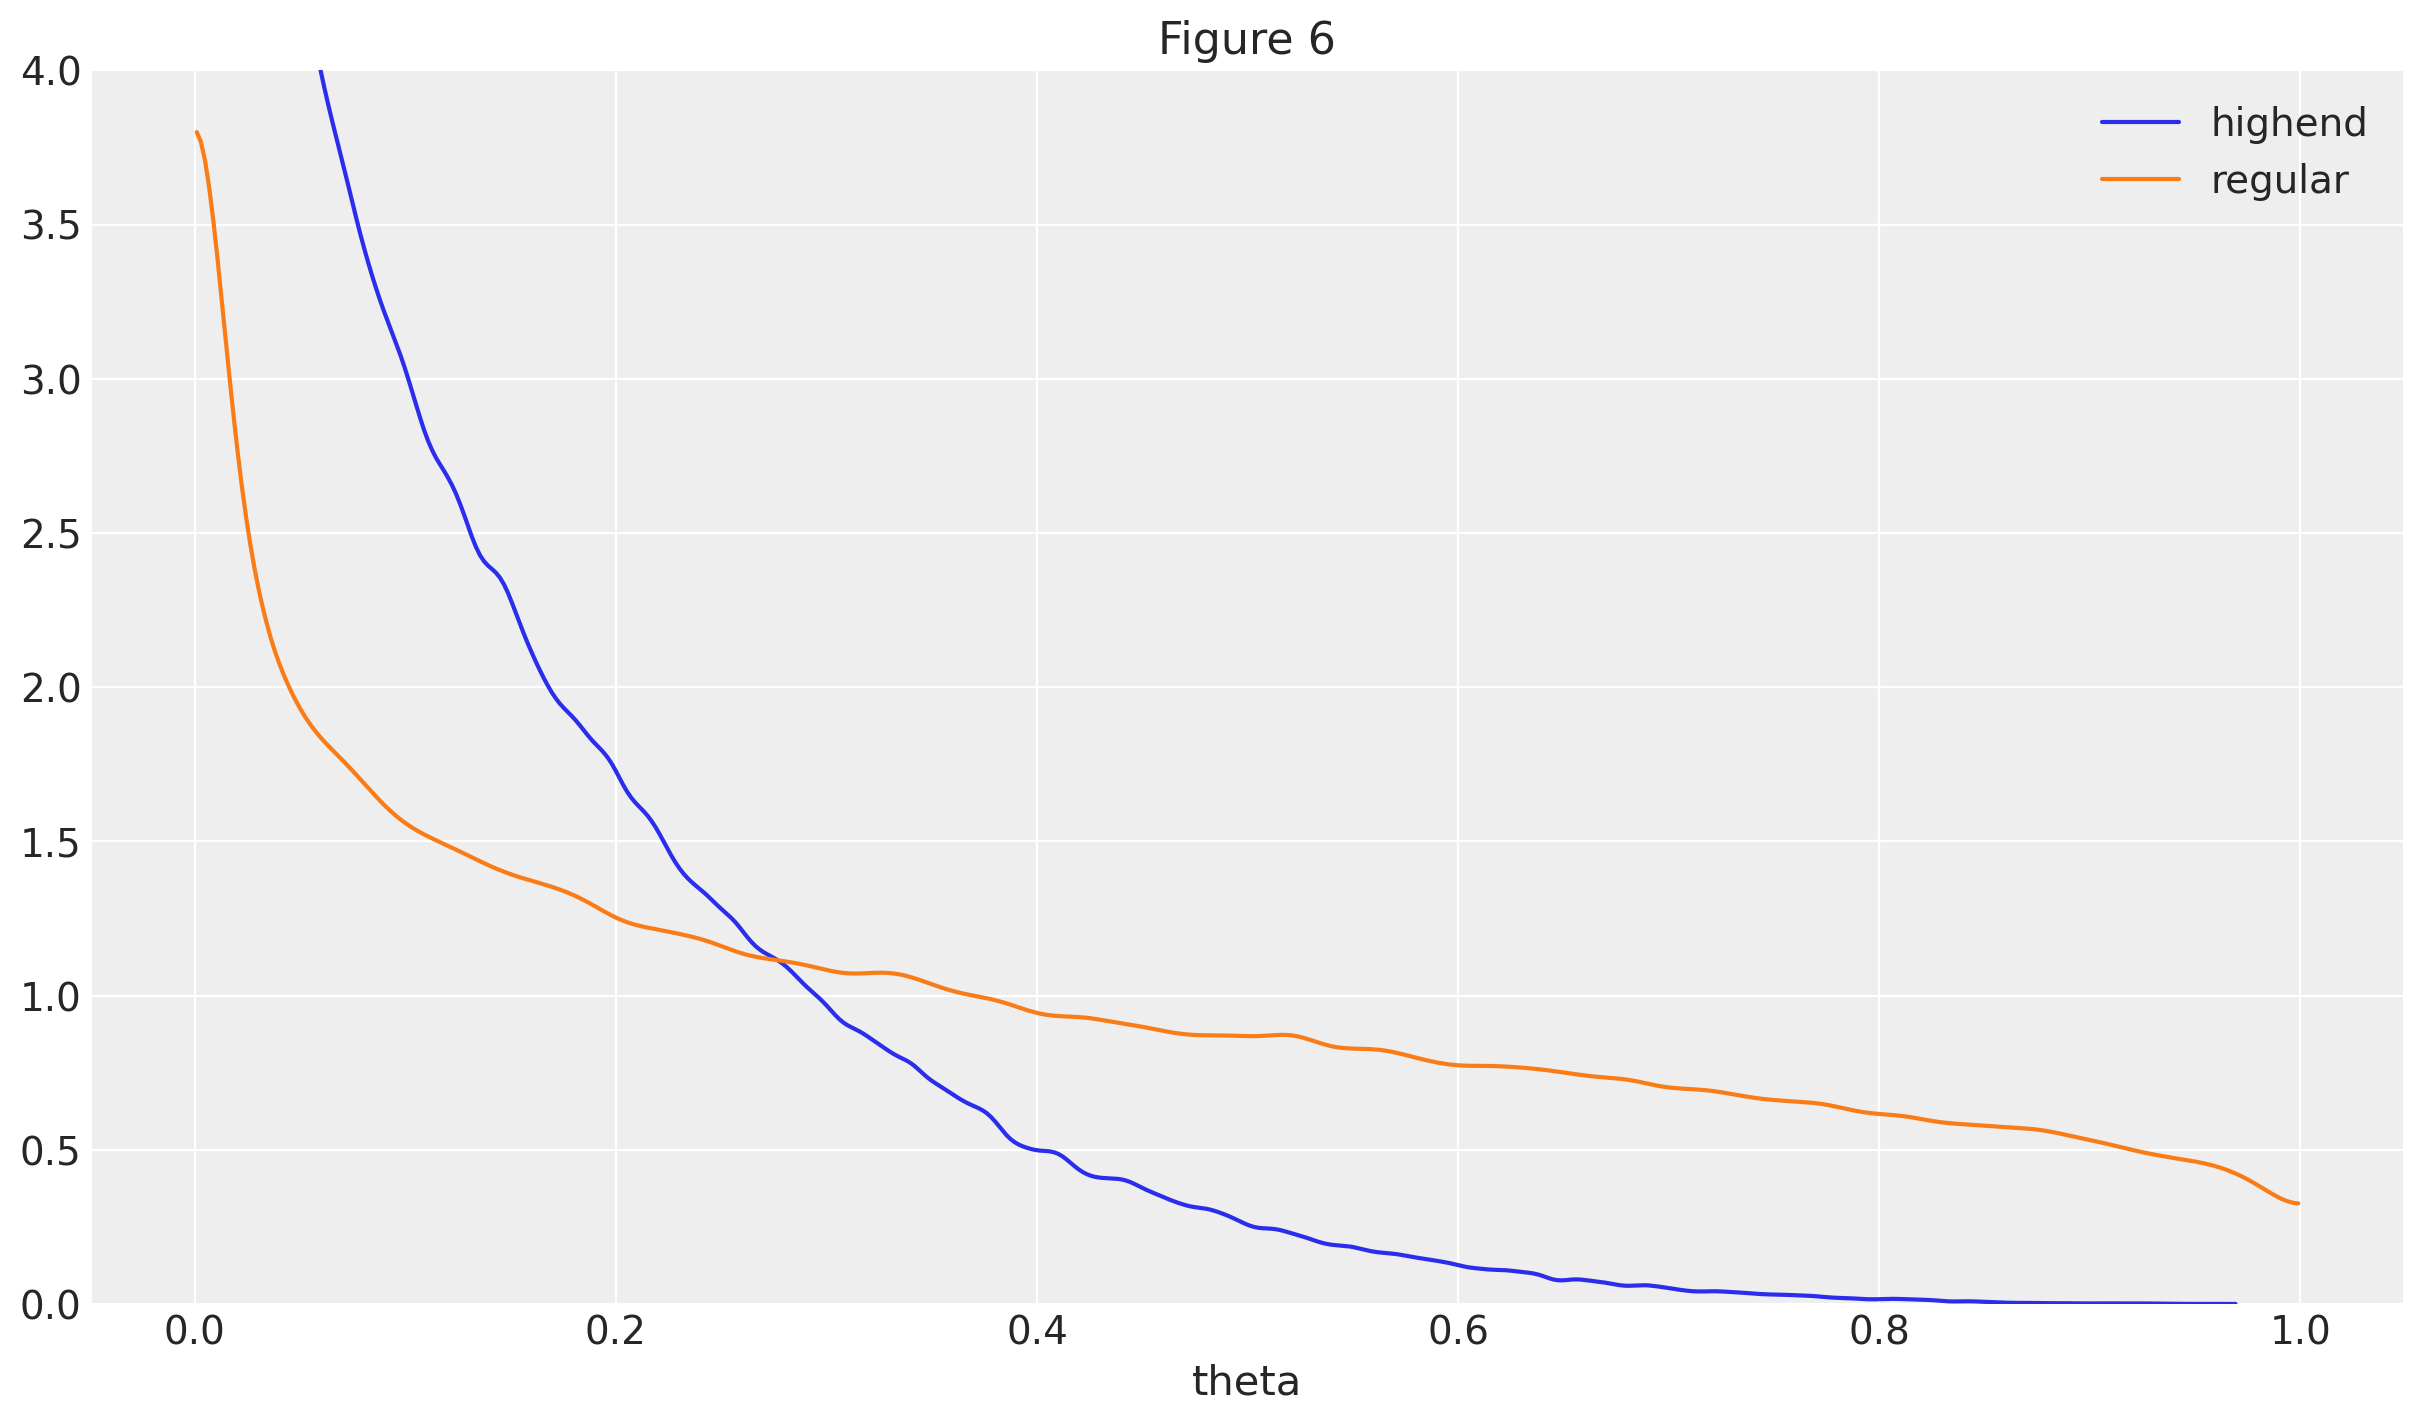

In [19]:
ax = az.plot_dist(new_highend_theta, label="highend")
ax = az.plot_dist(new_regular_theta, label="regular", ax=ax, color="C1")
ax.set_xlabel("theta")
plt.ylim([0, 4])
ax.set_title("Figure 6");

Figures 4 and 5 show the predicted average churn and retention trends for the two groups.
We can see that predictions nicely match the observed data (black line), even when extrapolating into the time periods that were held-out when fitting the model.

The plots also highlight an interesting implication from the model: 
the retention rates are expected to increase over time, as the more precarious customers gradually drop out. This is a direct consequence of modelling individual churn rates as being fixed over time.

In [20]:
churn_highend = highend_users.distribution_customer_churn_time(
    customer_id=np.arange(initial_customers),
    random_seed=rng,
)
churn_regular = regular_users.distribution_customer_churn_time(
    customer_id=np.arange(initial_customers),
    random_seed=rng,
)

Sampling: [churn]


Output()

Sampling: [churn]


Output()

In [21]:
weeks = xr.DataArray(np.arange(1, 14), dims=["weeks"])

survival_perc_highend = 100 - 100 * (churn_highend < weeks)
survival_perc_regular = 100 - 100 * (churn_regular < weeks)

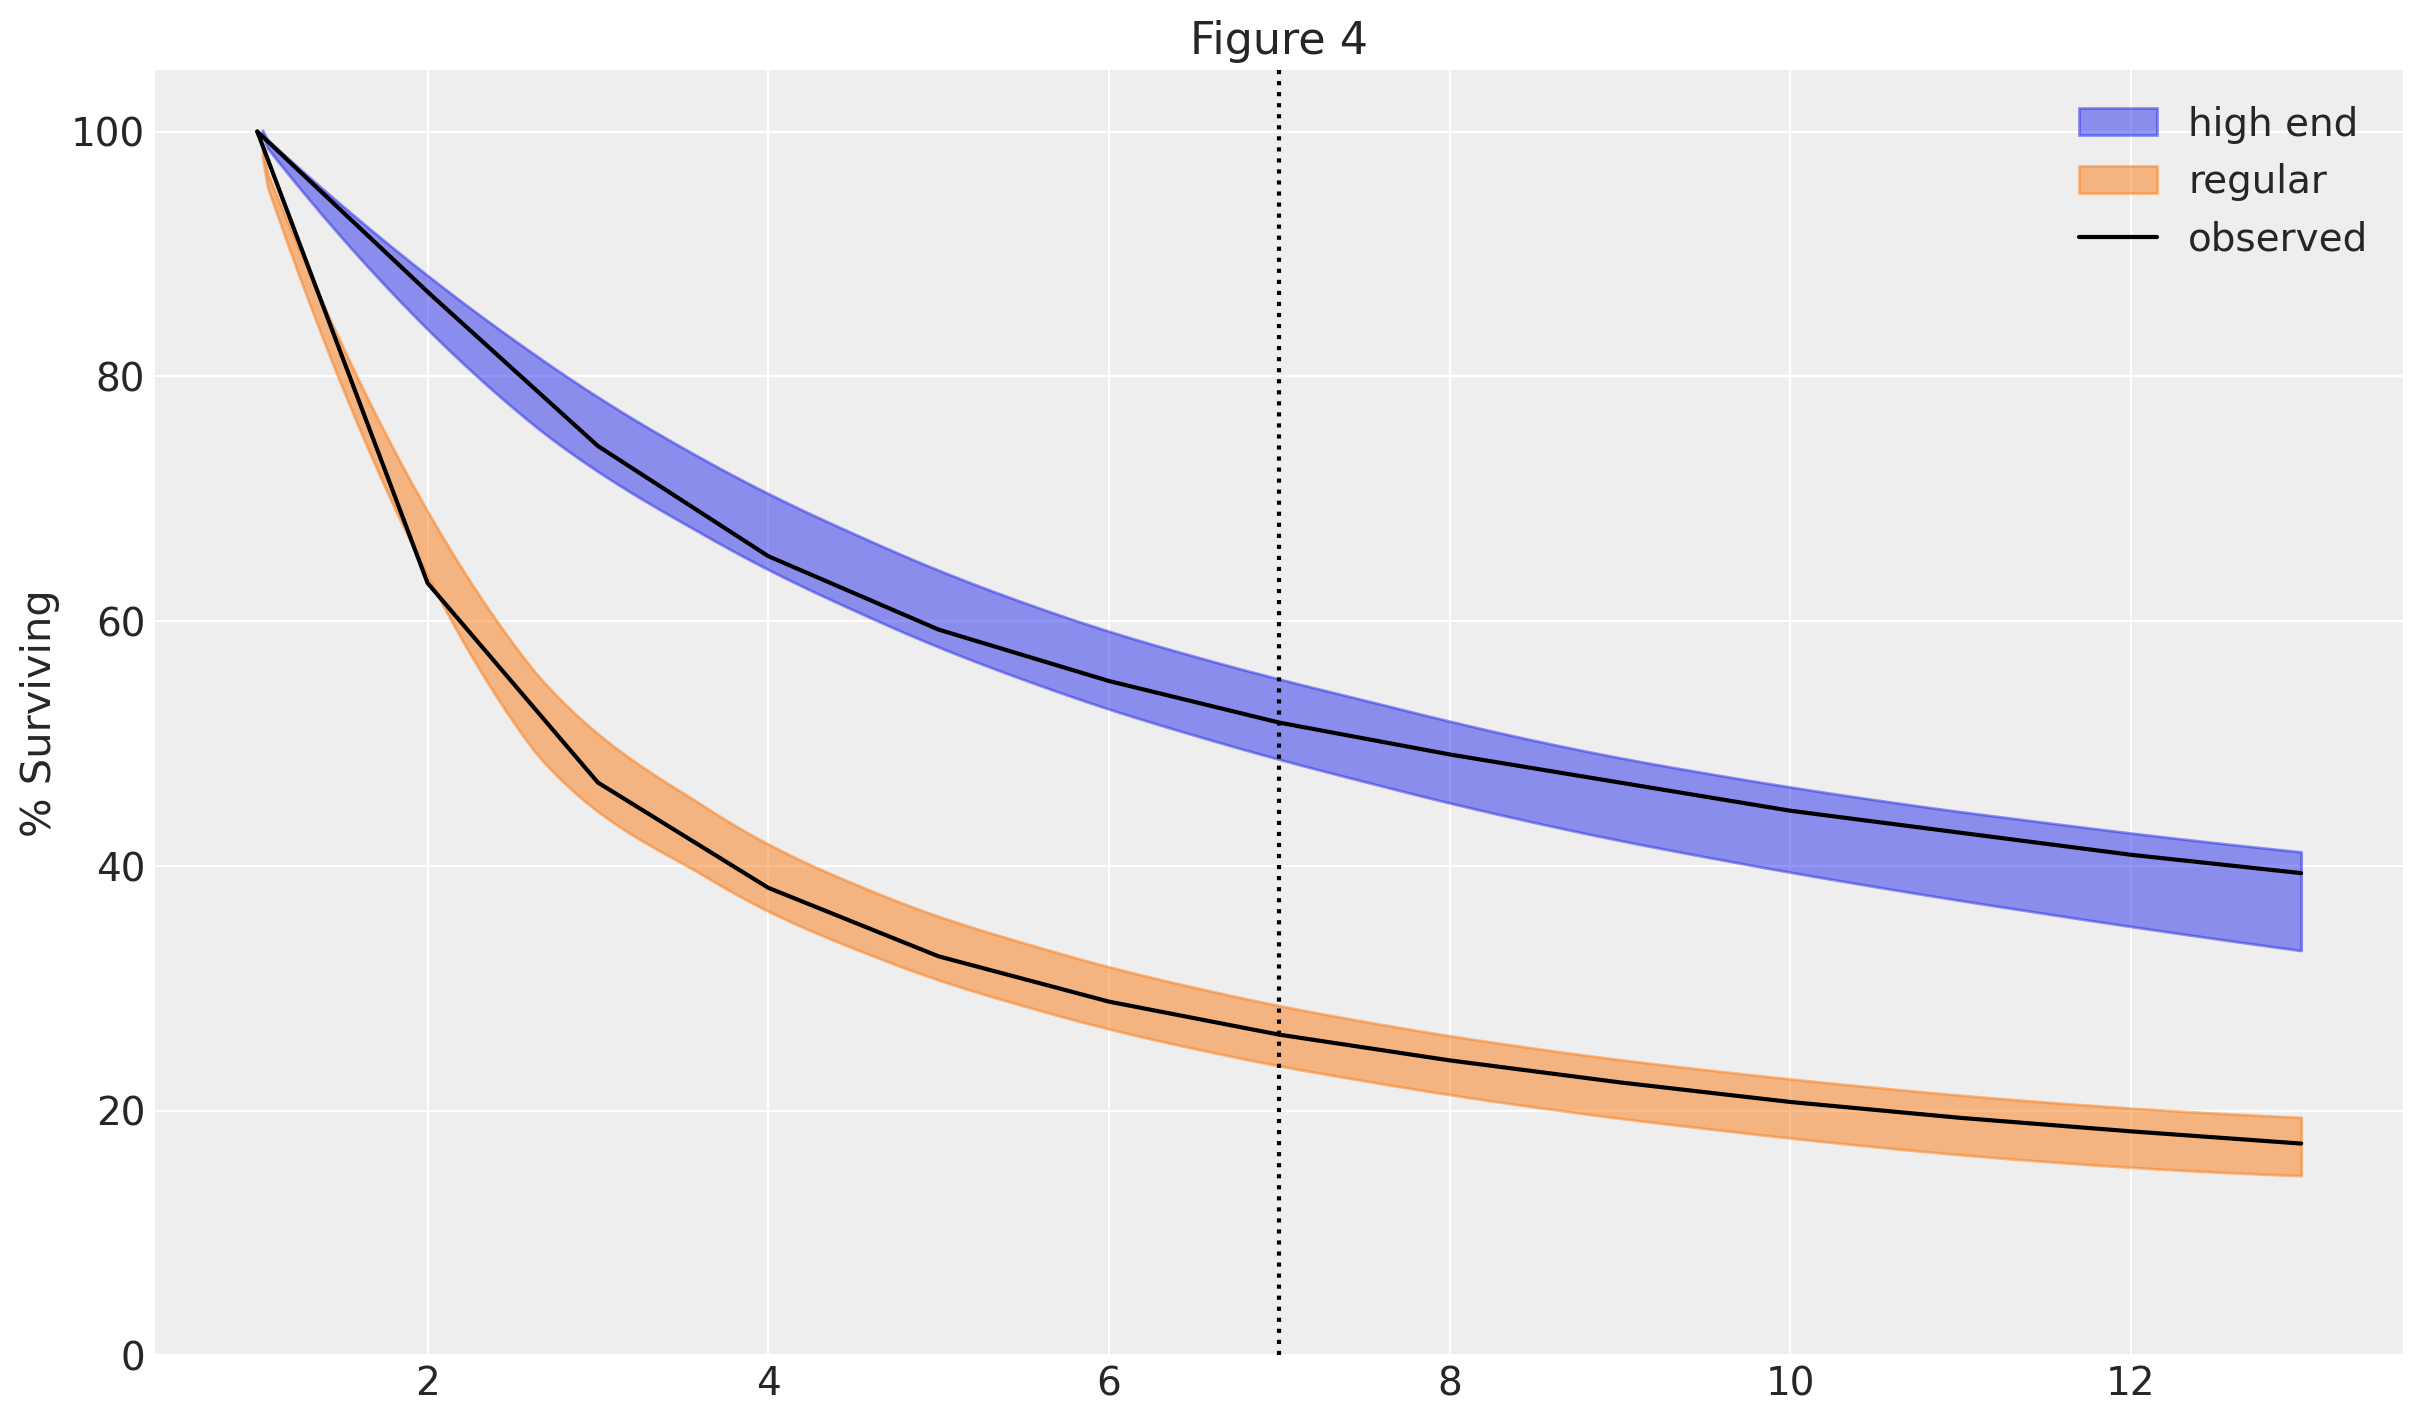

In [22]:
az.plot_hdi(
    weeks,
    survival_perc_highend.mean("customer_id"),
    hdi_prob=0.95,
    color="C0",
    fill_kwargs={"label": "high end"},
)
az.plot_hdi(
    weeks,
    survival_perc_regular.mean("customer_id"),
    hdi_prob=0.95,
    color="C1",
    fill_kwargs={"label": "regular"},
)

plt.plot(weeks, df["highend"], color="k", label="observed")
plt.plot(weeks, df["regular"], color="k")

plt.axvline(7, ls=":", color="k")
plt.ylim([0, 105])
plt.ylabel("% Surviving")
plt.legend()
plt.title("Figure 4");

In [23]:
retention_rate_highend = survival_perc_highend.isel(
    weeks=slice(1, None, None)
) / survival_perc_highend.isel(weeks=slice(None, -1, None))
retention_rate_regular = survival_perc_regular.isel(
    weeks=slice(1, None, None)
) / survival_perc_regular.isel(weeks=slice(None, -1, None))

retention_rate_highend_obs = df["highend"][1:].values / df["highend"][:-1].values
retention_rate_regular_obs = df["regular"][1:].values / df["regular"][:-1].values

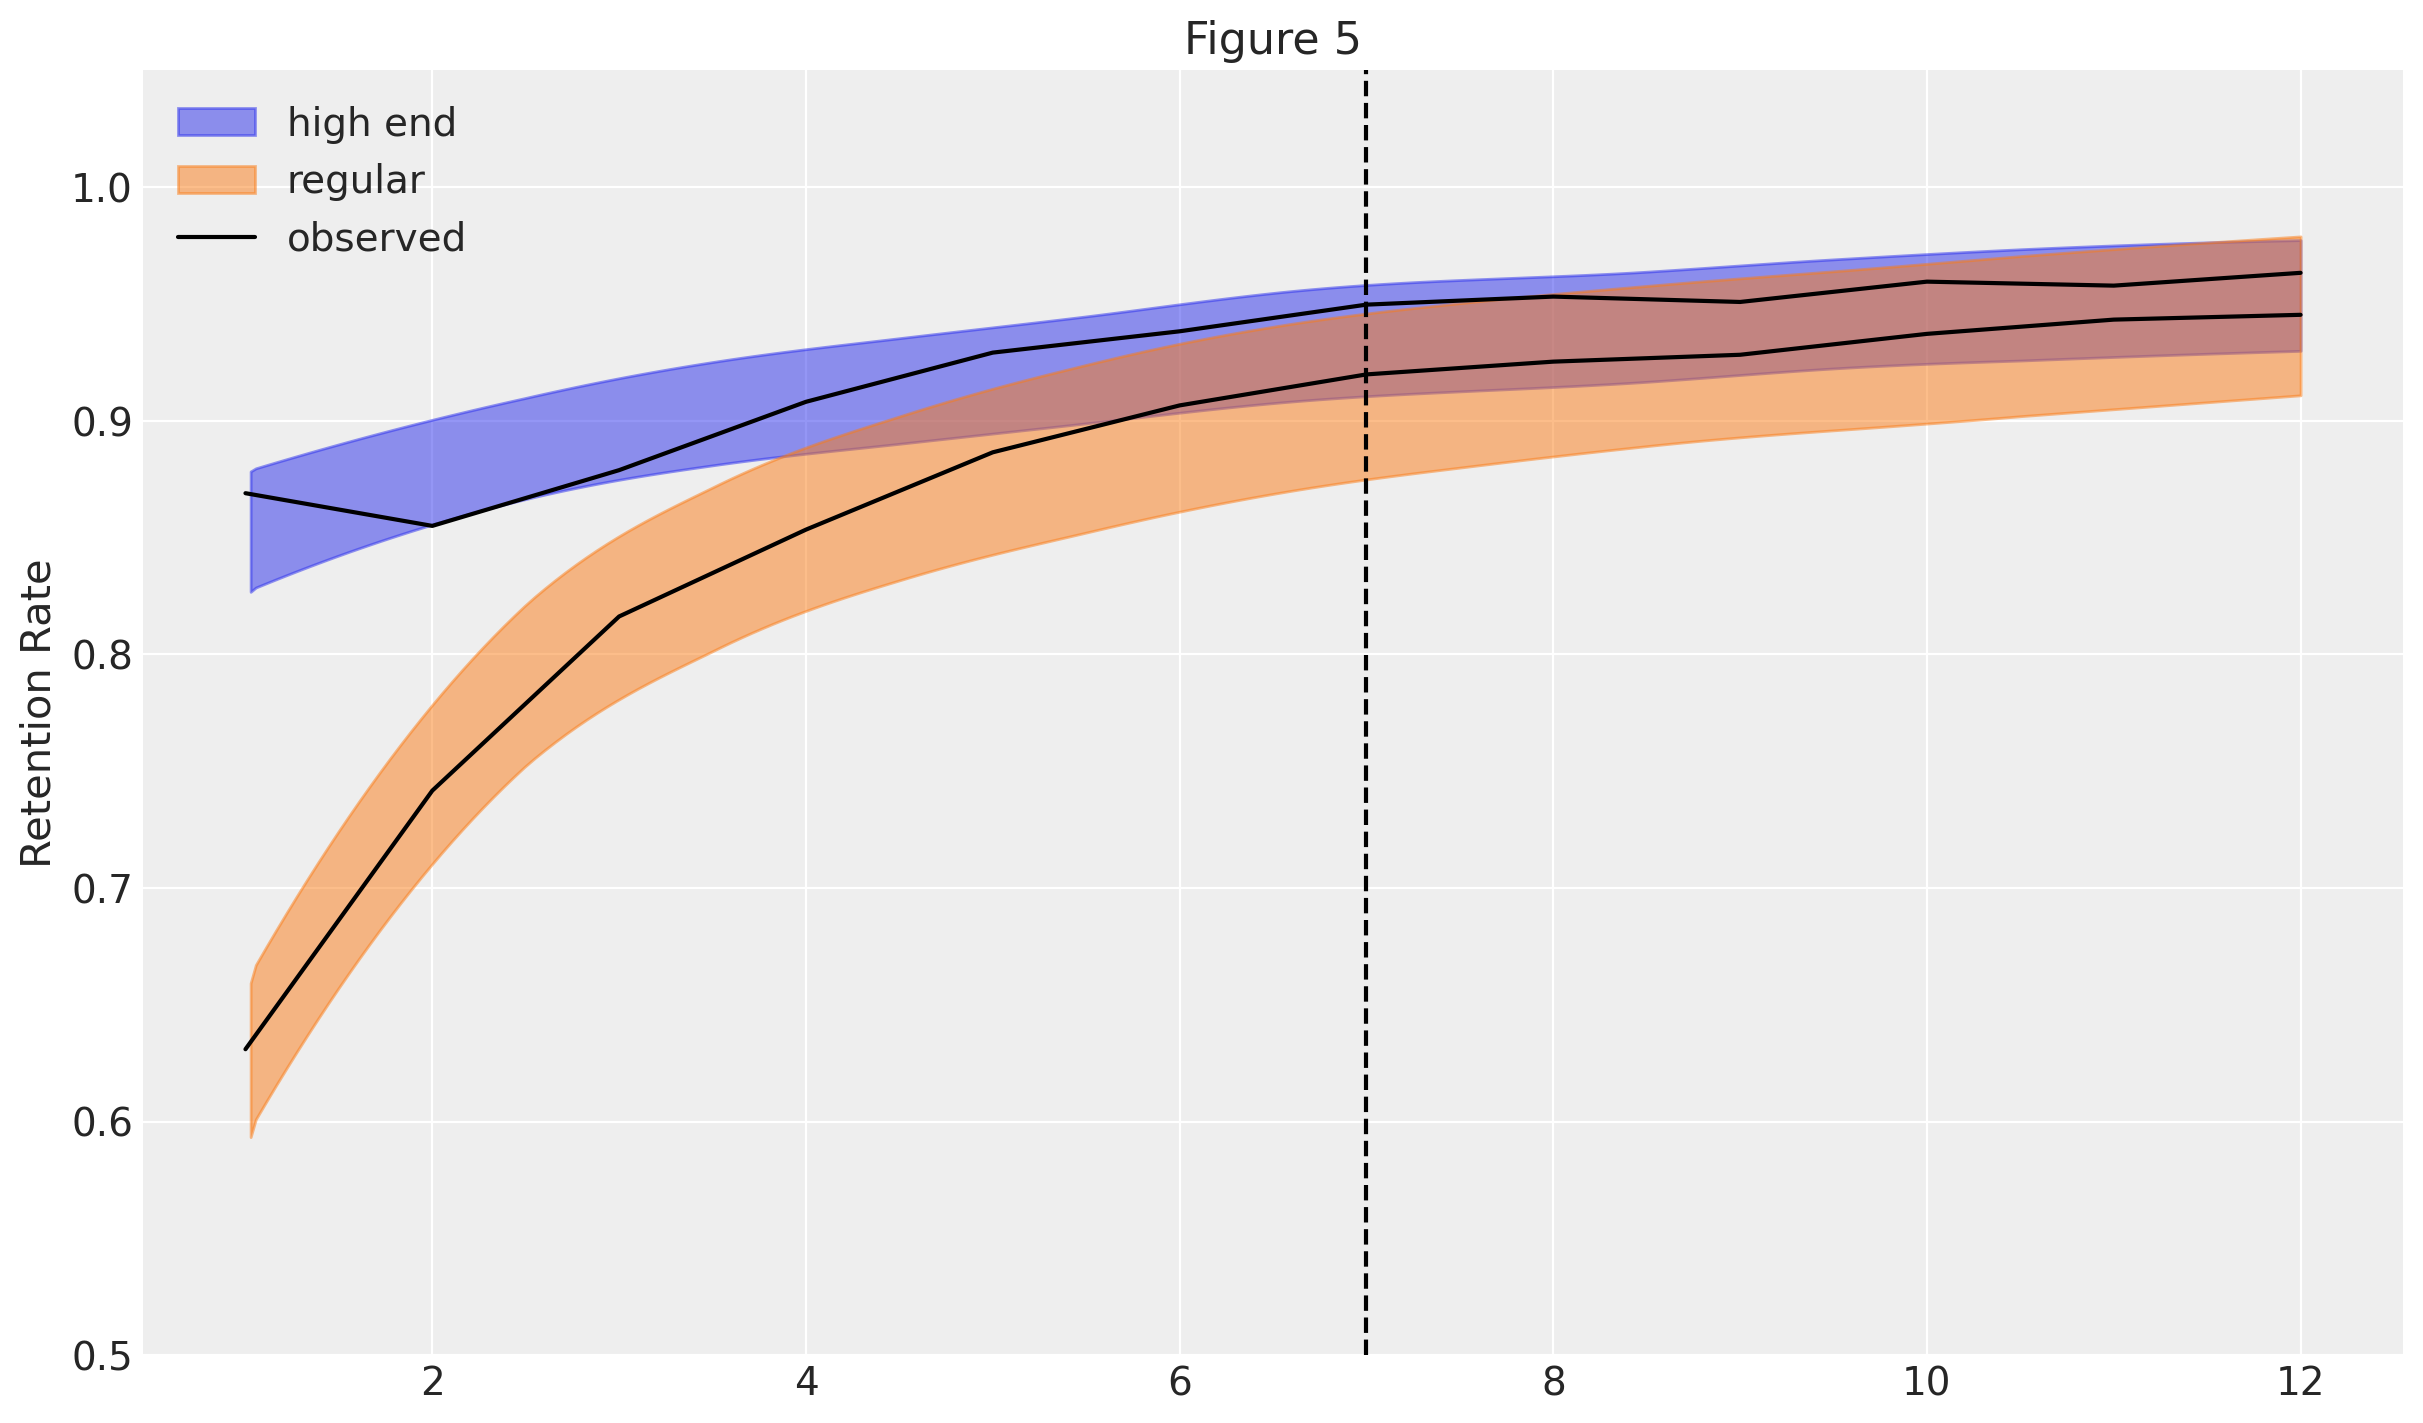

In [24]:
weeks_ = weeks[:-1]

az.plot_hdi(
    weeks_,
    retention_rate_highend.mean("customer_id"),
    hdi_prob=0.95,
    color="C0",
    fill_kwargs={"label": "high end"},
)
az.plot_hdi(
    weeks_,
    retention_rate_regular.mean("customer_id"),
    hdi_prob=0.95,
    color="C1",
    fill_kwargs={"label": "regular"},
)

plt.plot(weeks_, retention_rate_highend_obs, color="k", label="observed")
plt.plot(weeks_, retention_rate_regular_obs, color="k")

plt.axvline(7, ls="--", color="k")
plt.ylim([0.5, 1.05])
plt.ylabel("Retention Rate")
plt.legend()
plt.title("Figure 5");

In [25]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Mon Nov 11 2024

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.26.0

pymc    : 5.13.0
pytensor: 2.20.0

arviz         : 0.19.0
matplotlib    : 3.8.4
pandas        : 2.2.2
xarray        : 2024.6.0
pymc_marketing: 0.10.0
numpy         : 1.26.4

Watermark: 2.4.3

